# 오토인코더
- GAN은 세상에 존재하지 않는 완전한 가상의 것을 만들어 내는 반면에, 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어냄

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, Reshape, Flatten

from tensorflow.keras.datasets import mnist

In [4]:
#MNIST 데이터 셋 불러오기
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [2]:
# 생성자 모델 만들기
autoencoder = Sequential()

# 인코딩 부분
    # 입력된 값의 차원을 축소시키는 인코딩 부분
    # 입력 크기를 줄이는 방법으로 맥스 풀링 사용
        # 풀링 : 컨볼루션 층을 통해 도출한 이미지의 특징이 크고 복잡하면 이를 다시 한 번 축소하는 과정
        # 맥스풀링 : 정해진 구역 안에서 최댓값을 뽑아냄
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu')) # 입력 크기 : 28x28
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 크기 절반으로 감소 : 14x14
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) # 크기 절반으로 감소 : 7x7
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # 크기 감소 : 4x4

# 디코딩 부분
    # 다시 차원을 점차 늘려 입력 값과 똑같은 크기의 출력 값을 내보내는 디코딩 부분
    # UpSampling : 크기를 늘리기 위한 것
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 크기 : 4x4
autoencoder.add(UpSampling2D()) # 크기 두배로 증가 : 8x8
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) 
autoencoder.add(UpSampling2D()) # 크기 두배로 증가 : 16x16
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu')) # 크기 감소(padding='same'이 없어서 3x3 커널이 훑고 지나가면서 차원 2 감소) : 14x14
autoencoder.add(UpSampling2D()) # 크기 두배로 증가 : 28x28
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조 확인
    # 인코딩과 디코딩이 하나의 Sequential() 함수로 쭉 이어져 오토인코더 모델이 됨
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)          

In [6]:
# 컴파일 및 학습 진행
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

with tf.device('/GPU:0'):
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 5s 5ms/step - loss: 0.2170 - val_loss: 0.1421
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1313 - val_loss: 0.1210
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1175 - val_loss: 0.1120
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1105 - val_loss: 0.1067
Epoch 5/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1061 - val_loss: 0.1041
Epoch 6/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1030 - val_loss: 0.1004
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1006 - val_loss: 0.0984
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0988 - val_loss: 0.0969
Epoch 9/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0973 - val_loss: 0.0953
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0961 - val_loss: 0.0944

313/313 [==============================] - 1s 1ms/step


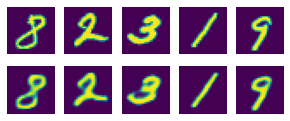

In [8]:
# 학습된 결과를 출력하는 부분
random_test = np.random.randint(X_test.shape[0], size=5)

# 테스트할 이미지를 랜덤으로 호출
ae_imgs = autoencoder.predict(X_test) # 앞서 만든 오토인코더 모델에 넣기

plt.figure(figsize=(7,2)) # 출력 이미지 크기 정하기

# enumerate() : 인덱스와 원소를 각각 다른 변수에 할당할 수 있음
for i, image_idx in enumerate(random_test):
    
    # 랜덤으로 뽑은 이미지를 차례로 나열
    ax = plt.subplot(2, 7, i+1)
    
    # 테스트할 이미지를 먼저 그대로 보여줌
    plt.imshow(X_test[image_idx].reshape(28, 28))
    ax.axis('off')
    ax = plt.subplot(2, 7, 7+i+1)
    
    # 오토인코딩 결과를 다음 열에 입력
    plt.imshow(ae_imgs[image_idx].reshape(28, 28))
    ax.axis('off')
    
plt.show()

In [ ]:
# 첫 번째 줄이 테스트로 사용된 원본이미지
# 두 번째 줄이 원본의 특징을 고스란히 담은 채 만들어진 오토인코더 이미지